In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-11 13:37:37.152147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 13:37:37.155623: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 13:37:37.165063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744378657.183480    7111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744378657.187917    7111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 13:37:37.207468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")


In [5]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")
reddit_results.rename(columns={"date": "date_hour"}, inplace=True)
reddit_results.set_index("date_hour", inplace=True)

reddit_results

,total_sentiment,average_sentiment
date_hour,,
2021-01-01 00:00:00,0.2966,0.015611
2021-01-01 01:00:00,1.6673,0.049038
2021-01-01 02:00:00,0.4588,0.021848
2021-01-01 03:00:00,-0.4329,-0.020614
2021-01-01 04:00:00,0.0000,0.000000
...,...,...
2024-12-31 19:00:00,0.0000,0.000000
2024-12-31 20:00:00,0.0000,0.000000
2024-12-31 21:00:00,0.0000,0.000000


In [6]:
btc_ner = pd.read_parquet("/workspaces/fyp/crypto_news/data/7a.News_by_hour_filled_return_ner.parquet")
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [7]:
target_col = "target"

start_date = pd.to_datetime("2021-01-01 10:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,56.533261,317.624467,353.808641,367.447718,29496.559713,29199.137,28901.714287,29578.630359,28970.1450,28361.659641
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,56.598884,295.260971,340.042309,357.620684,29502.574589,29203.857,28905.139411,29589.347989,28974.4195,28359.491011
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,54.726979,304.073690,341.250001,357.588747,29487.240223,29221.956,28956.671777,29606.981982,28986.3910,28365.800018
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,52.258691,303.448877,338.282144,354.832140,29491.227042,29215.220,28939.212958,29610.913197,29006.8125,28402.711803
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,56.754682,310.279037,339.209134,354.662038,29478.397134,29244.203,29010.008866,29621.265856,29043.1435,28465.021144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.700,93232.332124,95433.425204,94002.9000,92572.374796
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.600,93046.804693,95435.711991,93998.4000,92561.088009
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.000,92943.728190,95434.444994,94007.2500,92580.055006


In [8]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
price_indicator_2024.index = pd.to_datetime(price_indicator_2024.index)
btc_ner.index = pd.to_datetime(btc_ner.index)
reddit_results.index = pd.to_datetime(reddit_results.index)

# Merge the DataFrames on the index (date_hour)
merged_df = pd.concat([price_indicator_2024, reddit_results], axis=1)

# Drop any rows with missing values (optional, if needed)
merged_df.dropna(inplace=True)

# Verify the merged DataFrame
# merged_df.drop("target",axis=1)
merged_df

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,353.808641,367.447718,29496.559713,29199.137,28901.714287,29578.630359,28970.1450,28361.659641,0.0000,0.000000
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,340.042309,357.620684,29502.574589,29203.857,28905.139411,29589.347989,28974.4195,28359.491011,0.0000,0.000000
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,341.250001,357.588747,29487.240223,29221.956,28956.671777,29606.981982,28986.3910,28365.800018,0.0000,0.000000
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,338.282144,354.832140,29491.227042,29215.220,28939.212958,29610.913197,29006.8125,28402.711803,0.8402,0.056013
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,339.209134,354.662038,29478.397134,29244.203,29010.008866,29621.265856,29043.1435,28465.021144,0.4404,0.017616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,594.021005,490.327871,95801.067876,94516.700,93232.332124,95433.425204,94002.9000,92572.374796,0.0000,0.000000
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,605.805219,503.121782,95876.395307,94461.600,93046.804693,95435.711991,93998.4000,92561.088009,0.0000,0.000000
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,594.033418,500.163602,95898.271810,94421.000,92943.728190,95434.444994,94007.2500,92580.055006,0.0000,0.000000


In [10]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
1970-01-01 00:00:00.000000000,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000001,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000002,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000003,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000004,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000032087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [11]:
btc_ner.set_index("date_hour", inplace=True)
merged_df = pd.merge(merged_df, btc_ner, on='date_hour', how='inner')
merged_df


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,29294.58,29300.15,29158.86,29242.10,293.434229,0.000118,-0.001648,147778.404811,29321.312,29199.137,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 11:00:00,29242.10,29317.56,29156.48,29245.54,289.686959,-0.002475,0.000118,148068.091770,29274.596,29203.857,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:00:00,29245.54,29253.61,28896.66,29173.17,403.490558,-0.003290,-0.002475,147664.601212,29259.364,29221.956,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:00:00,29179.01,29247.40,28947.70,29077.20,305.297627,0.007065,-0.003290,147359.303585,29205.678,29215.220,...,0,0,0,0,0,0,0,0,0,0
2021-01-01 14:00:00,29060.43,29390.85,29039.59,29282.62,306.830396,0.001214,0.007065,147666.133981,29204.126,29244.203,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.200,94516.700,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.200,94461.600,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.800,94421.000,...,0,0,0,0,0,0,0,0,0,0


In [12]:
merged_df.drop(columns=['target'], inplace=True)

# Statistical Feature Selection

In [13]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,42600.0,42643.0,42500.0,42537.0,33.104355,-0.000729,-0.001385,165799.040531,42589.2,42528.8,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 02:00:00,42537.0,42640.0,42506.0,42506.0,46.611812,-0.005929,-0.000729,165752.428719,42575.4,42529.3,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 03:00:00,42506.0,42563.0,42096.0,42254.0,126.372266,0.000095,-0.005929,165626.056453,42506.4,42511.2,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 04:00:00,42246.0,42332.0,42072.0,42258.0,66.348207,0.005017,0.000095,165692.404660,42430.2,42491.4,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 05:00:00,42258.0,42533.0,42257.0,42470.0,40.031310,0.003061,0.005017,165732.435970,42405.0,42488.3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0,0,0,0,0,0,0,0,0,0


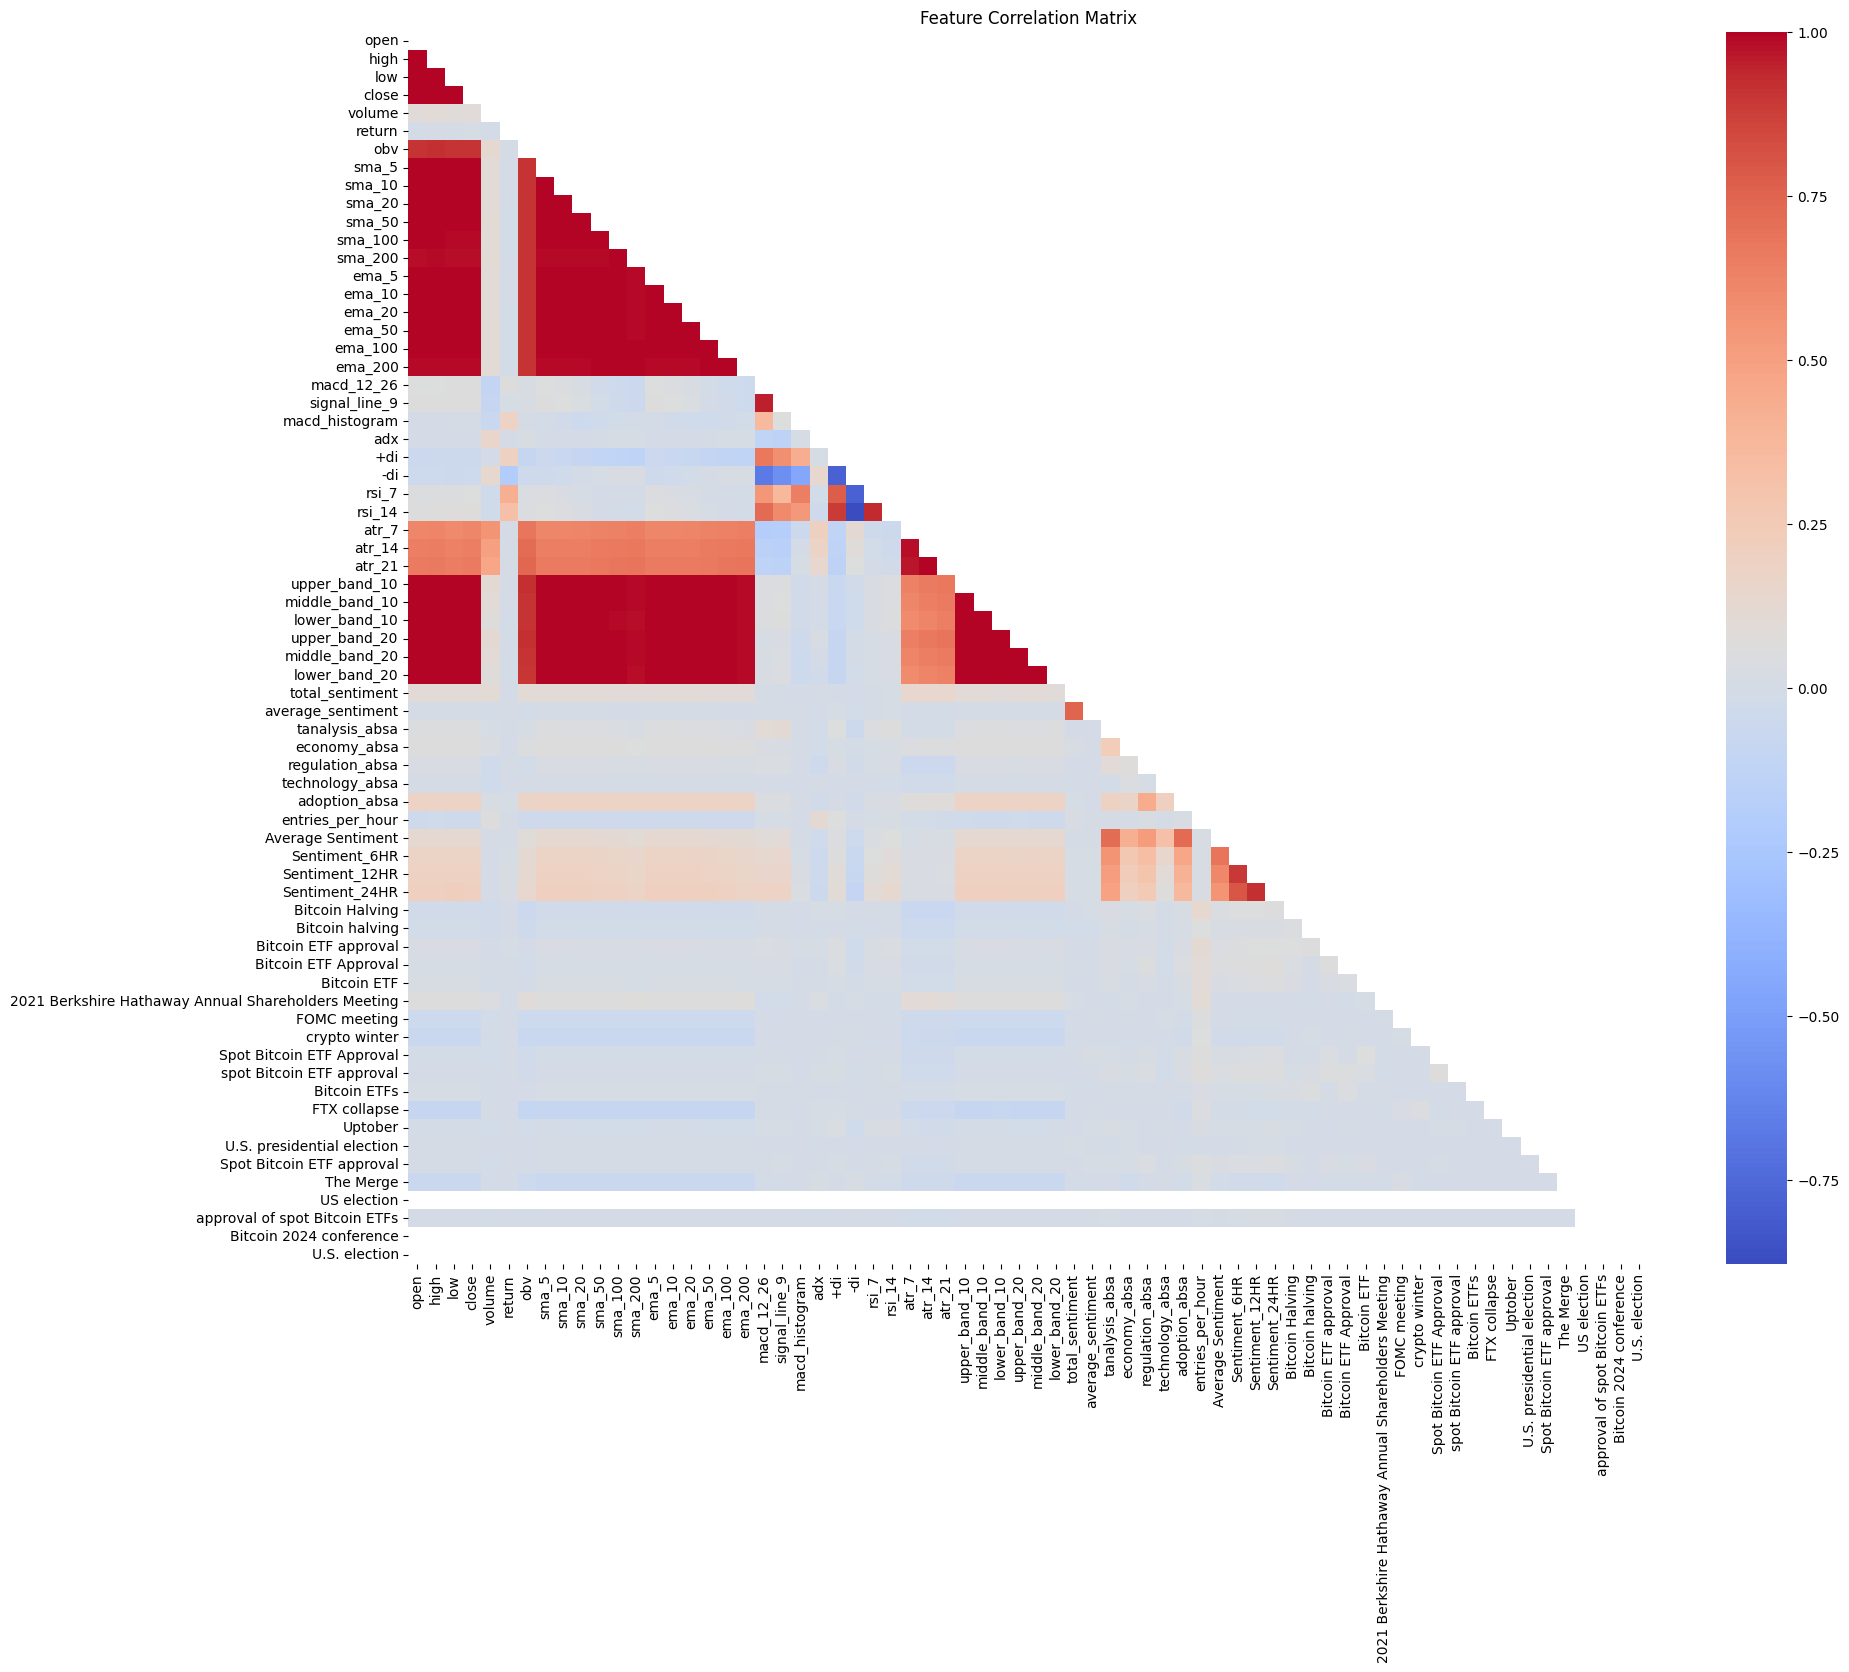

In [14]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [15]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 68 to 40
Top features selected: ['open', 'low', 'close', 'volume', 'ema_5', 'atr_7', 'atr_14', 'lower_band_10', 'lower_band_20', 'total_sentiment', 'tanalysis_absa', 'Average Sentiment', 'Sentiment_6HR', 'Sentiment_12HR', 'Sentiment_24HR']


Index(['open', 'low', 'close', 'volume', 'ema_5', 'atr_7', 'atr_14',
       'lower_band_10', 'lower_band_20', 'total_sentiment', 'tanalysis_absa',
       'Average Sentiment', 'Sentiment_6HR', 'Sentiment_12HR',
       'Sentiment_24HR'],
      dtype='object')

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[selected_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (31898, 12, 15)
y shape: (31898, 1)
Total sequences: 31898
Training sequences: 28708
Testing sequences: 3190


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    # Calculate returns
    returns = y_pred - y_true
    
    # Define weights for positive and negative returns
    positive_weight = 0.5
    negative_weight = 1.5
    
    # Calculate weighted loss
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


def nbeats_block(input_layer, units, block_type='trend', num_layers=4):
    # Create a block of fully connected layers
    x = input_layer
    for _ in range(num_layers):
        x = Dense(units, activation='relu')(x)

    # Create the forecast and backcast outputs
    if block_type == 'trend':
        forecast = Dense(units=1, activation='linear')(x)
    elif block_type == 'seasonal':
        forecast = Dense(units=1, activation='linear')(x)
    
    backcast = Dense(units=input_layer.shape[-1], activation='linear')(x)

    return backcast, forecast

def build_nbeats(input_shape, num_blocks, units, num_layers):
    inputs = Input(shape=input_shape)
    residuals = inputs
    forecasts = []

    for _ in range(num_blocks):
        # Create trend block
        backcast, forecast = nbeats_block(residuals, units=units, block_type='trend', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

        # Create seasonal block
        backcast, forecast = nbeats_block(residuals, units=units, block_type='seasonal', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

    # Combine all forecasts
    output = Add()(forecasts)
    model = Model(inputs, output)
    return model

# Define model architecture
input_shape = (X_train.shape[1],)
model = build_nbeats(
    input_shape=input_shape,
    num_blocks=3,
    units=128,
    num_layers=4
)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

2025-04-11 13:37:41.649297: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0516 - val_loss: 0.0015
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0038 - val_loss: 9.2711e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0025 - val_loss: 8.1866e-04
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0022 - val_loss: 9.1778e-04
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0020 - val_loss: 9.2689e-04
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0018 - val_loss: 6.9420e-04
Epoch 8/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0016 - val_loss: 6.4285e-04
Epoch 9/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0015 - val_loss: 6.0626e-04
Epoch 10/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0015 - val_loss: 5.9817e-04
Epoch 11/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0014 - val_loss: 5.9643e-04
Epoc

array([[-0.00020567],
       [-0.00025284],
       [-0.00026826],
       ...,
       [ 0.00080697],
       [ 0.00010365],
       [ 0.00076549]], dtype=float32)

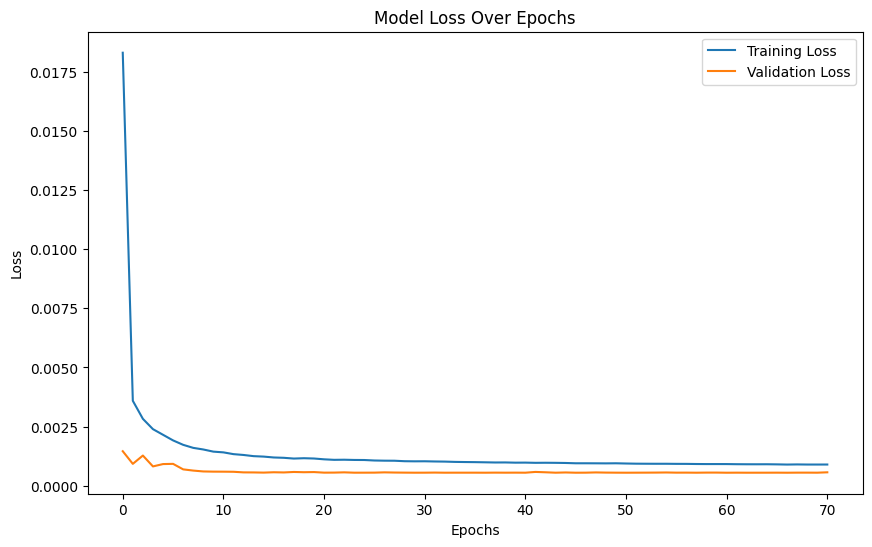

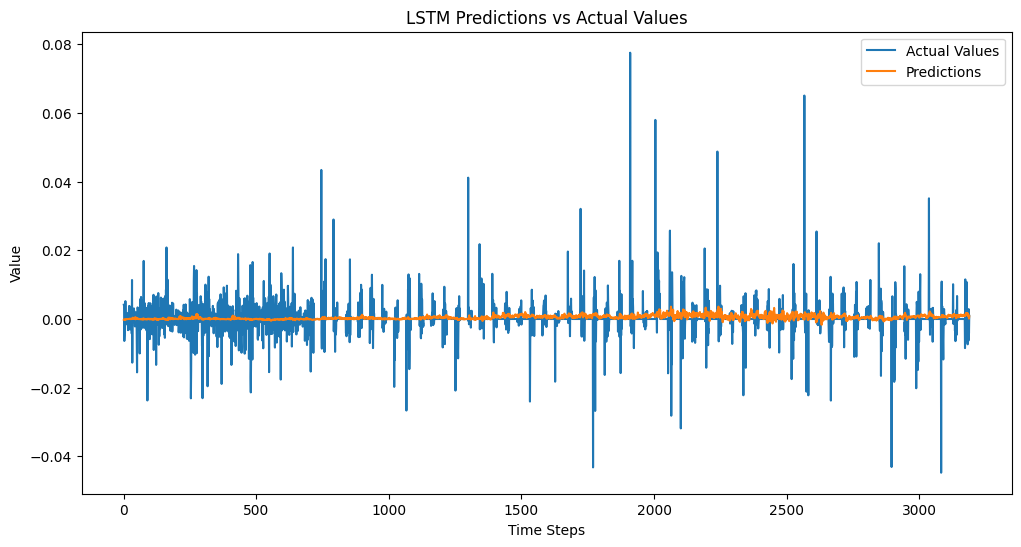

In [18]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [19]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)


In [20]:
model.save('sequential_selection_lstm_model.keras')  # HDF5 format


In [21]:
y_test

array([[0.51824897],
       [0.51688698],
       [0.4755583 ],
       ...,
       [0.51300764],
       [0.48469075],
       [0.50521762]])

In [44]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Actual,Predicted
2024-08-16 22:00:00,0.004154,2.551305e-05
2024-08-16 23:00:00,0.003817,-3.586920e-06
2024-08-17 00:00:00,-0.006399,2.439352e-06
2024-08-17 01:00:00,-0.004771,-2.369905e-05
2024-08-17 02:00:00,-0.000576,-2.089956e-05
...,...,...
2024-12-31 19:00:00,0.002666,-5.723373e-06
2024-12-31 20:00:00,-0.006308,-1.871890e-05
2024-12-31 21:00:00,0.002858,6.859871e-07
2024-12-31 22:00:00,-0.004142,-1.172018e-05


In [45]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > -0.060 else (-1 if x < -0.055 else 0))
stat_signal_result_df

,Predicted,signal
2024-08-16 22:00:00,2.551305e-05,1
2024-08-16 23:00:00,-3.586920e-06,1
2024-08-17 00:00:00,2.439352e-06,1
2024-08-17 01:00:00,-2.369905e-05,1
2024-08-17 02:00:00,-2.089956e-05,1
...,...,...
2024-12-31 19:00:00,-5.723373e-06,1
2024-12-31 20:00:00,-1.871890e-05,1
2024-12-31 21:00:00,6.859871e-07,1
2024-12-31 22:00:00,-1.172018e-05,1


Overall Annual Return: 265.74%
Overall Annual Sharpe Ratio: 2.8715
Maximum Drawdown: -17.21 %
Alpha: 0.0
Beta: 1.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       2.657428    0.494147          1.0           0.0        2.87152


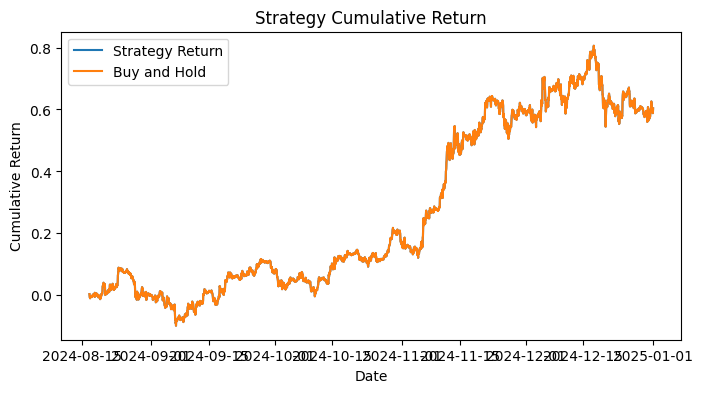

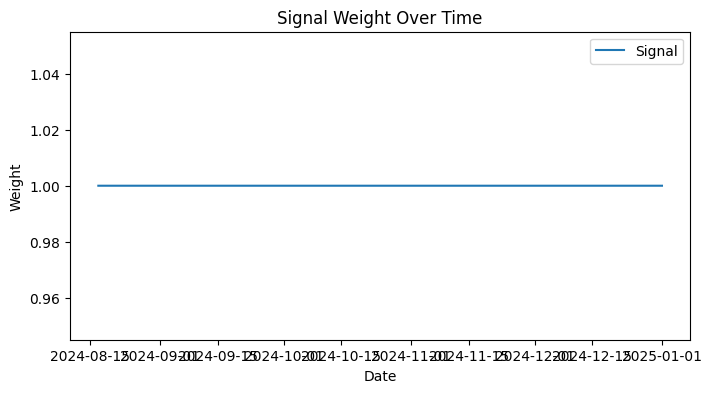

In [46]:
run_backtest(stat_signal_result_df)

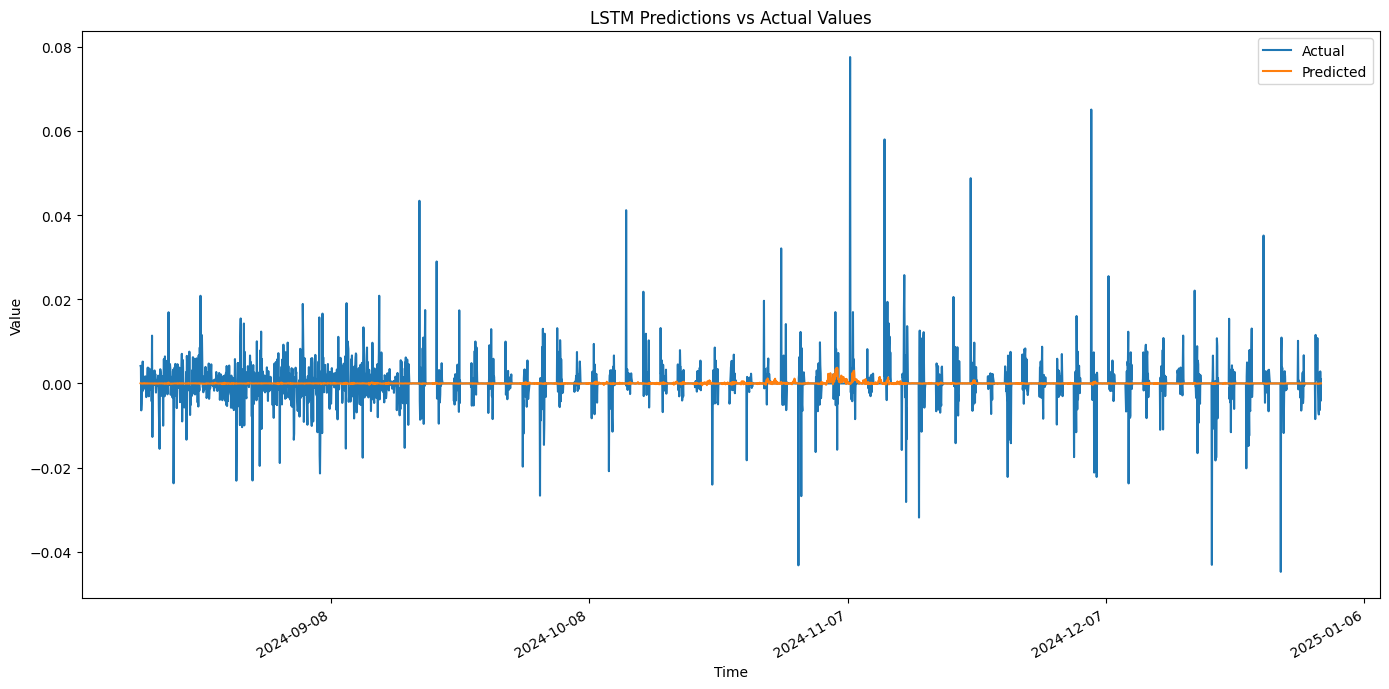

In [47]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [48]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[lstm_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (31898, 12, 15)
y shape: (31898, 1)
Total sequences: 31898
Training sequences: 28708
Testing sequences: 3190


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add

@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    # Calculate returns
    returns = y_pred - y_true
    
    # Define weights for positive and negative returns
    positive_weight = 0.5
    negative_weight = 1.5
    
    # Calculate weighted loss
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


def nbeats_block(input_layer, units, block_type='trend', num_layers=4):
    # Create a block of fully connected layers
    x = input_layer
    for _ in range(num_layers):
        x = Dense(units, activation='relu')(x)

    # Create the forecast and backcast outputs
    if block_type == 'trend':
        forecast = Dense(units=1, activation='linear')(x)
    elif block_type == 'seasonal':
        forecast = Dense(units=1, activation='linear')(x)
    
    backcast = Dense(units=input_layer.shape[-1], activation='linear')(x)

    return backcast, forecast

def build_nbeats(input_shape, num_blocks, units, num_layers):
    inputs = Input(shape=input_shape)
    residuals = inputs
    forecasts = []

    for _ in range(num_blocks):
        # Create trend block
        backcast, forecast = nbeats_block(residuals, units=units, block_type='trend', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

        # Create seasonal block
        backcast, forecast = nbeats_block(residuals, units=units, block_type='seasonal', num_layers=num_layers)
        residuals = Add()([residuals, backcast])
        forecasts.append(forecast)

    # Combine all forecasts
    output = Add()(forecasts)
    model = Model(inputs, output)
    return model

# Define model architecture
input_shape = (X_train.shape[1],)
model = build_nbeats(
    input_shape=input_shape,
    num_blocks=3,
    units=128,
    num_layers=4
)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100


718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0520 - val_loss: 6.8557e-04
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0043 - val_loss: 6.5101e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0030 - val_loss: 8.4738e-04
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0023 - val_loss: 8.0489e-04
Epoch 5/100
249/718 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0020

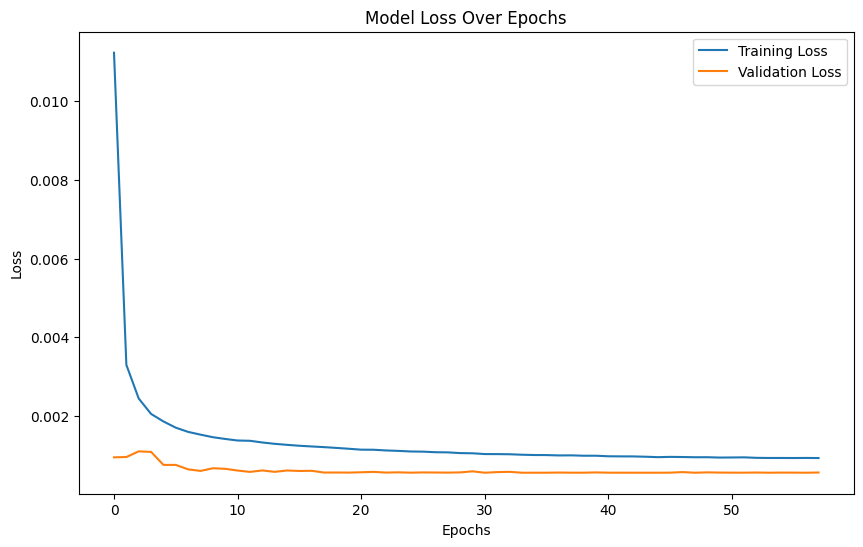

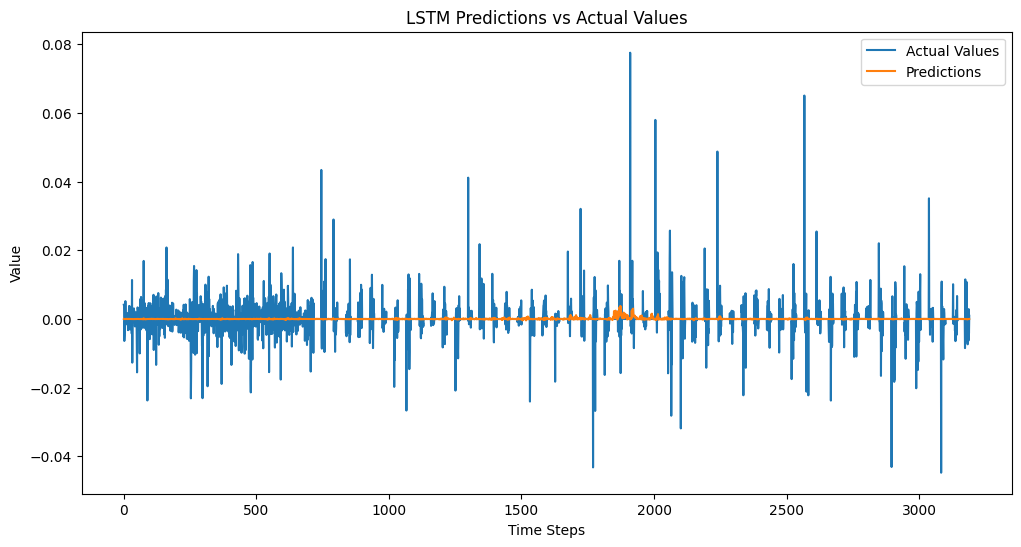

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

model.save('stat_features_selection_lstm_model.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < 0.0001 else 0))
stat_signal_result_df

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Predicted,signal
2024-08-16 22:00:00,2.551305e-05,-1
2024-08-16 23:00:00,-3.586920e-06,-1
2024-08-17 00:00:00,2.439352e-06,-1
2024-08-17 01:00:00,-2.369905e-05,-1
2024-08-17 02:00:00,-2.089956e-05,-1
...,...,...
2024-12-31 19:00:00,-5.723373e-06,-1
2024-12-31 20:00:00,-1.871890e-05,-1
2024-12-31 21:00:00,6.859871e-07,-1
2024-12-31 22:00:00,-1.172018e-05,-1


Overall Annual Return: -3.19%
Overall Annual Sharpe Ratio: 0.1813
Maximum Drawdown: -23.64 %
Alpha: 2.1987
Beta: -0.7563

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.031885    0.494378    -0.756308      1.162809       0.181325


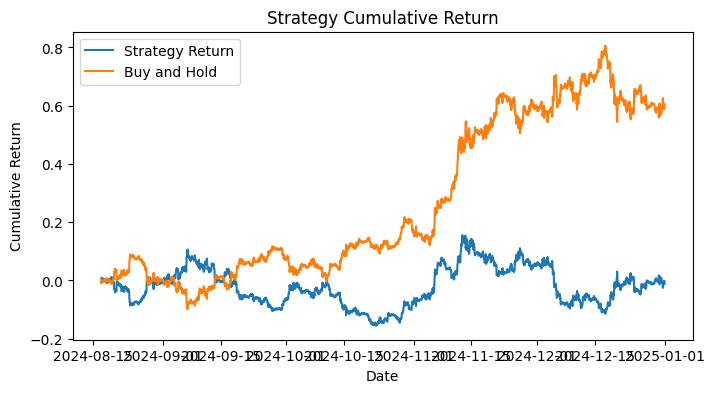

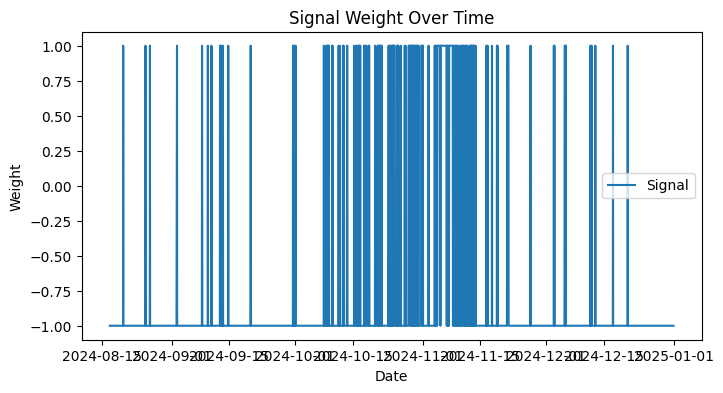

In [ ]:
run_backtest(stat_signal_result_df)